# Part - B :- Neural Network vs. Perceptron

#### in this part of the assignment, we apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results.

We begin by loading the required libraries.

In [2]:
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


We now define the auxiliary fuunctions required. We will create a new data structure called list to store the results and a read.data function to read the data in the required format.Also we define an error rate function to calculate the errors.

In [6]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

We now begin by loading the data and plotting the dataset as done below.

In [25]:
####################### Assignment 2.B #######################
# Read the datasets
set.seed(1234)          # set random seed
library(ggplot2)        # load libraries
list[X1,T1] <- read.data('Task2B_train.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 
list[X2,T2] <- read.data('Task2B_test.csv') # read test data
T2[T2==0] <- -1         # convert 0 labels to -1 



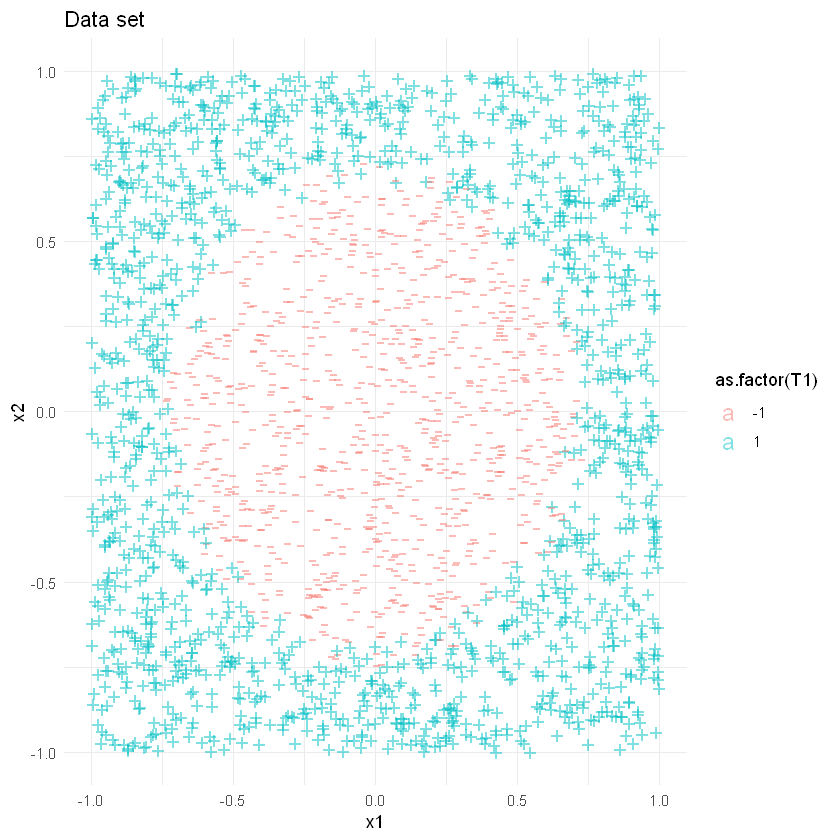

In [9]:
ggplot(data=X1, aes(x=x1, y=x2, color=as.factor(T1), label=ifelse(T1==+1, '+', '-'))) +
geom_text(size = 5, alpha=0.5) +
    ggtitle ('Data set') +
    theme_minimal()

We now build a set of auxiliary functions for building perceptron. The functions are, 
- perceptron.predict - to predict the labels.
- perceptron.build - to build the model.
- is.a.miss - updates weight vector if there is a misclassification.

In [10]:
# prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
# is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}
## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}


We now build the perceptron model and predict its labels. We then report the error rate of the perceptron.

Error Rate : 0.5168

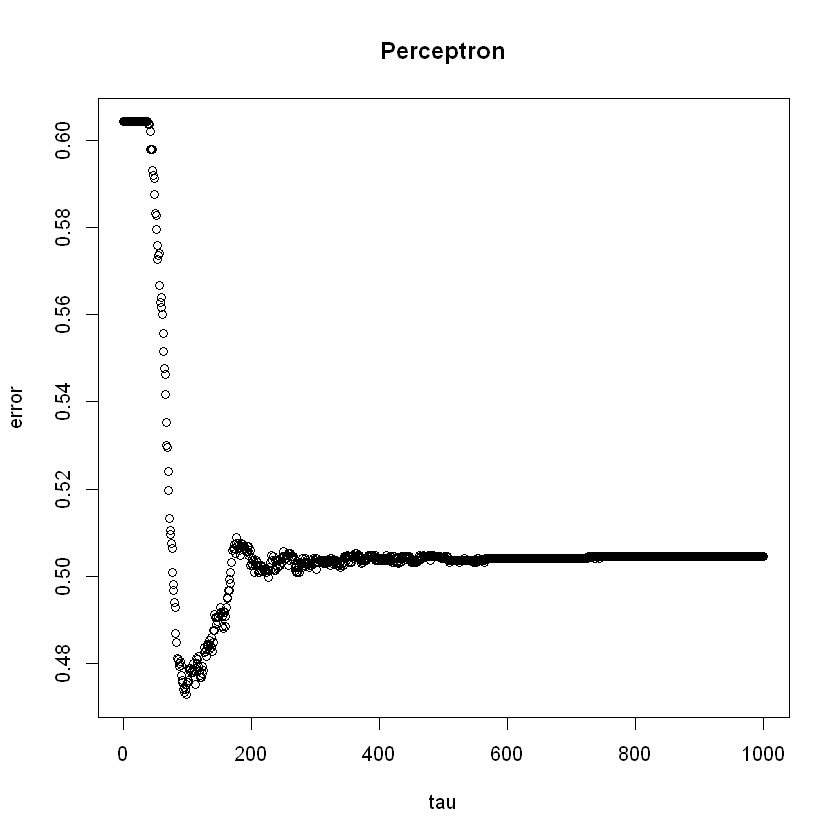

In [11]:
# Build a perceptron and plot its train error curve
W<-perceptron.build(X1, T1, tau.max = 1000, plotting = TRUE) # Run this a few times until you are happy with the result

# Evaluate Perceptron
Phi <- as.matrix(cbind(1,X2))

predict.label <- perceptron.predict(Phi,W)
test.error <- error.rate(predict.label,T2)
cat('Error Rate :',test.error)

We now plot the predicted labels with the assumed decision boundary. 

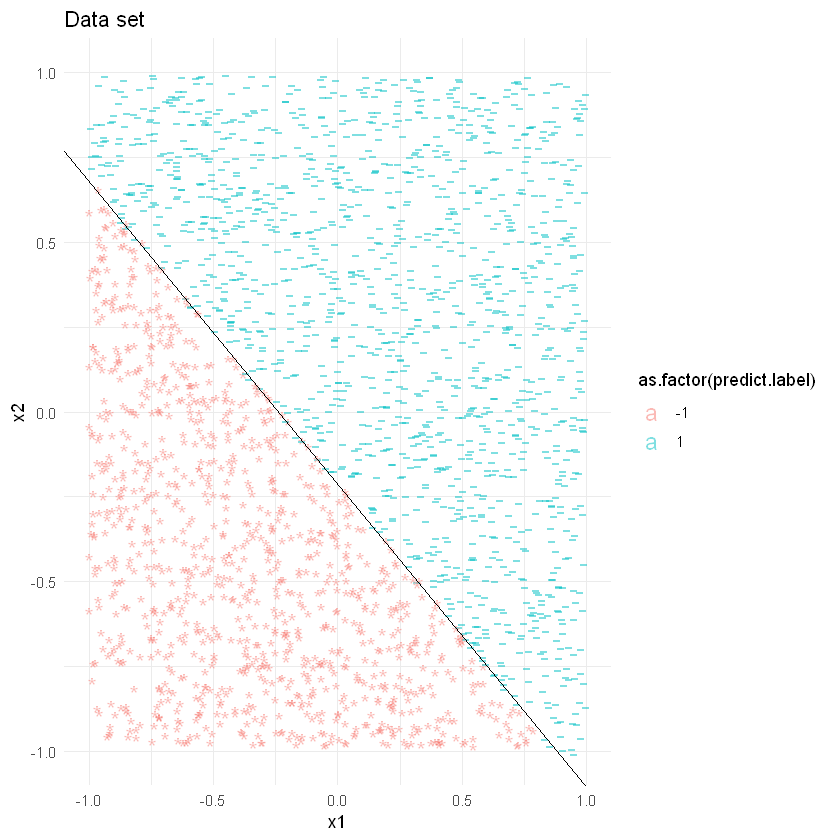

In [16]:
ggplot(data=X2, aes(x=x1, y=x2, color=as.factor(predict.label), label=ifelse(predict.label==+1, '-', '*'))) +
    geom_text(size = 5, alpha=0.5) +
    geom_abline(intercept=-W[1]/W[3], slope=-W[2]/W[3]) +
    ggtitle ('Data set') + theme_minimal()

We now build the auxilary funtions required to build the neural network.
- We build the h function which is the activation function which is tanh
- We build the derivative of the activation function.
- We build the function to compute class probabilities.
- We build a prediction function for neural net to perform some prediction on the test data.
- We build a feedforward and backproagation function 
- Finally we build a nn.build function to build the neural network model.

In [23]:
####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z, a=1) { #activation function (sigmoid here)
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function (tanh here)
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}
## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
  plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  return(list(W1, W2, b1, b2))
}




We now build various neural network models with number of neurons in the hidden layer ranging from 5 to 100 with a step of 5.

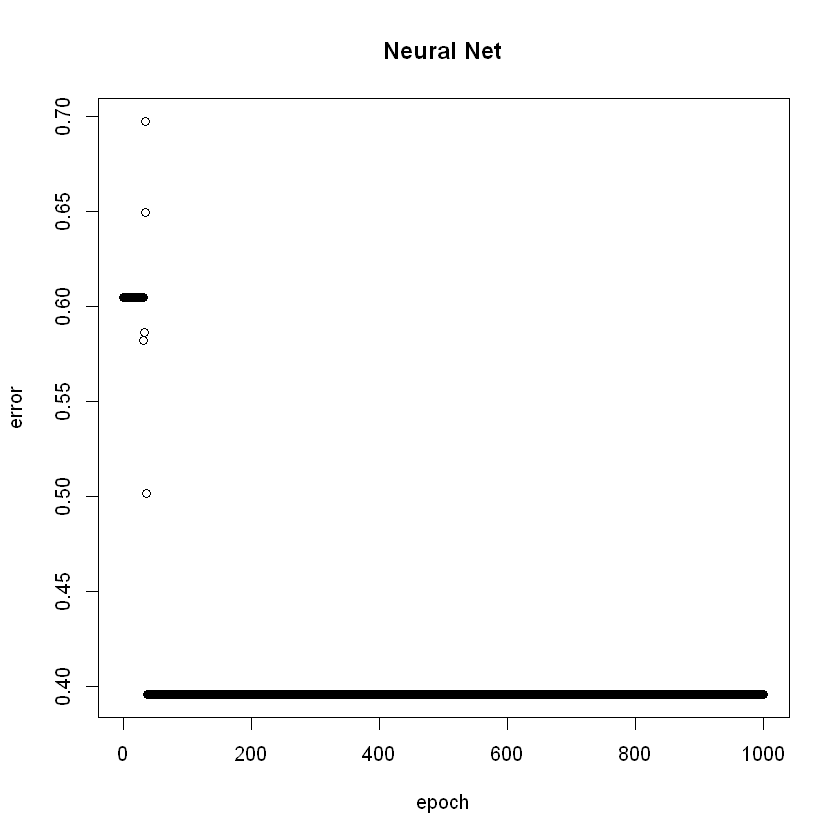

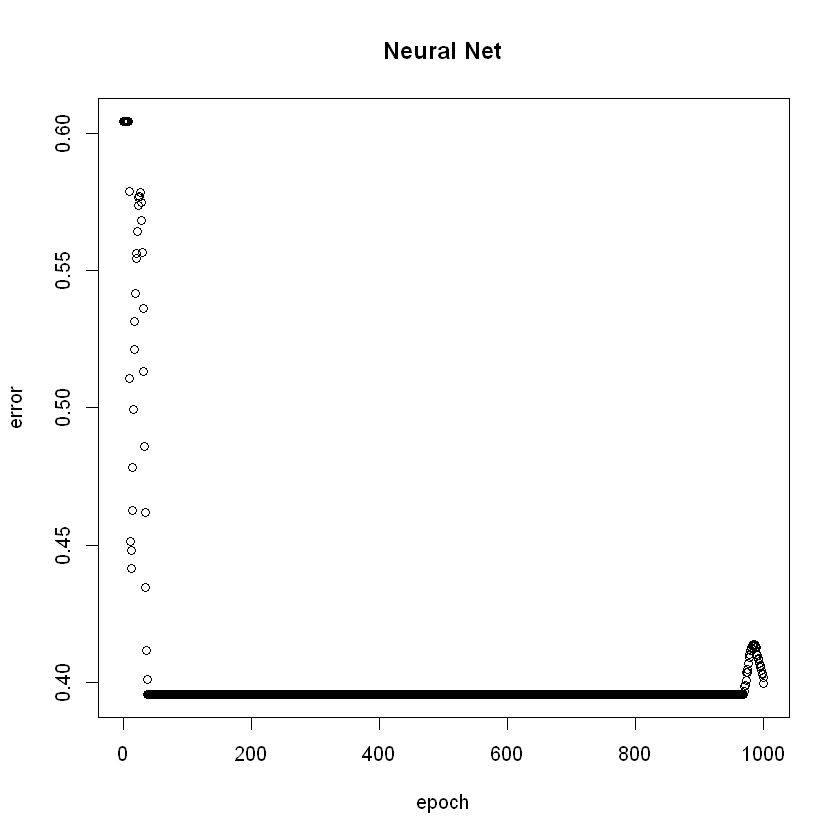

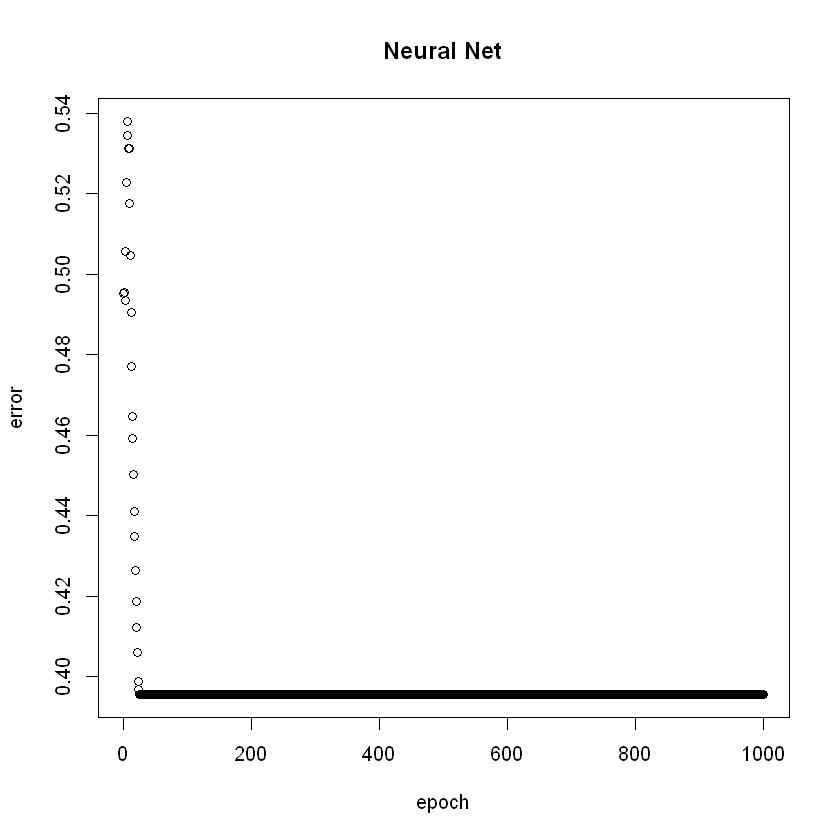

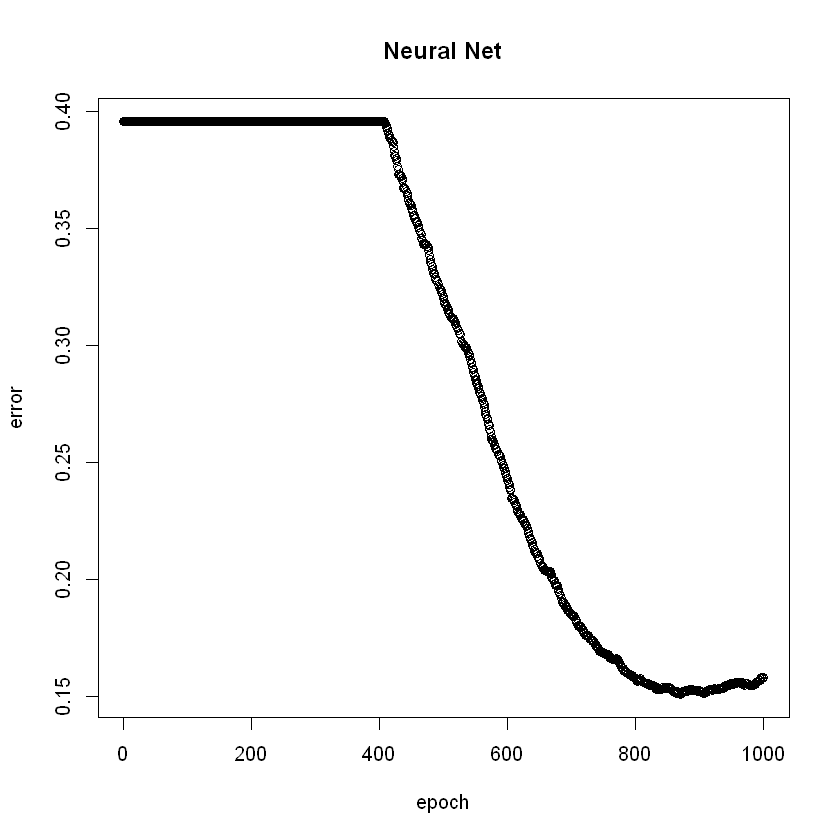

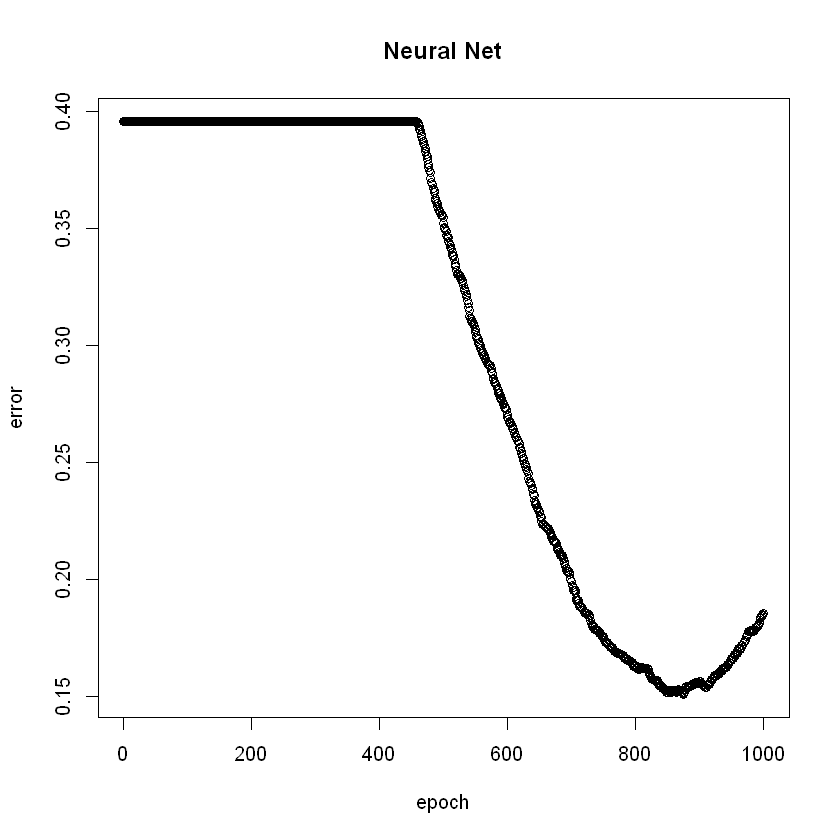

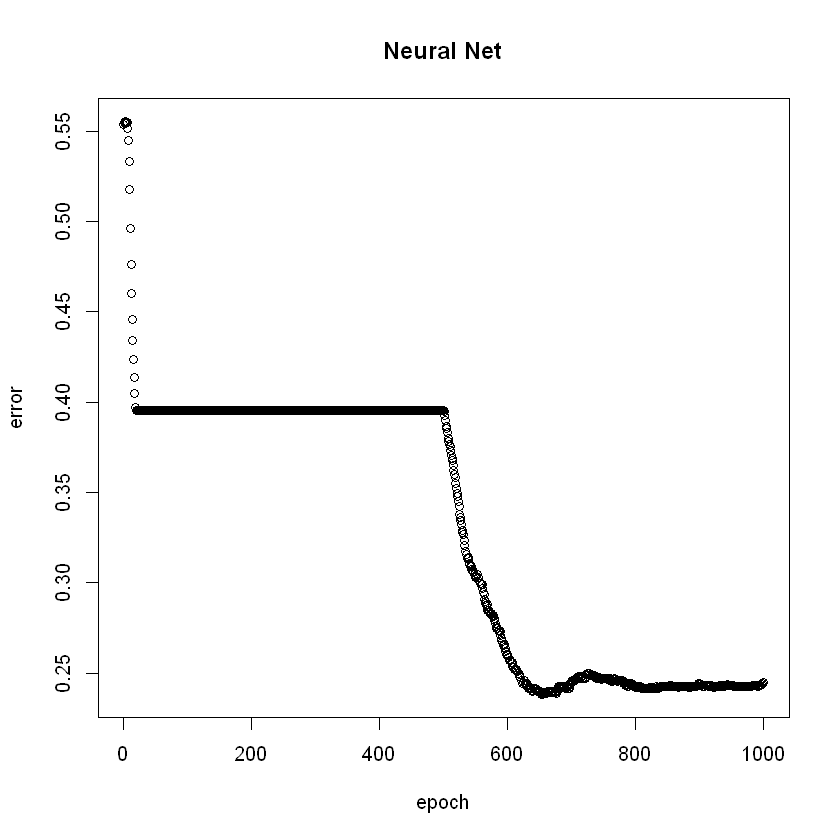

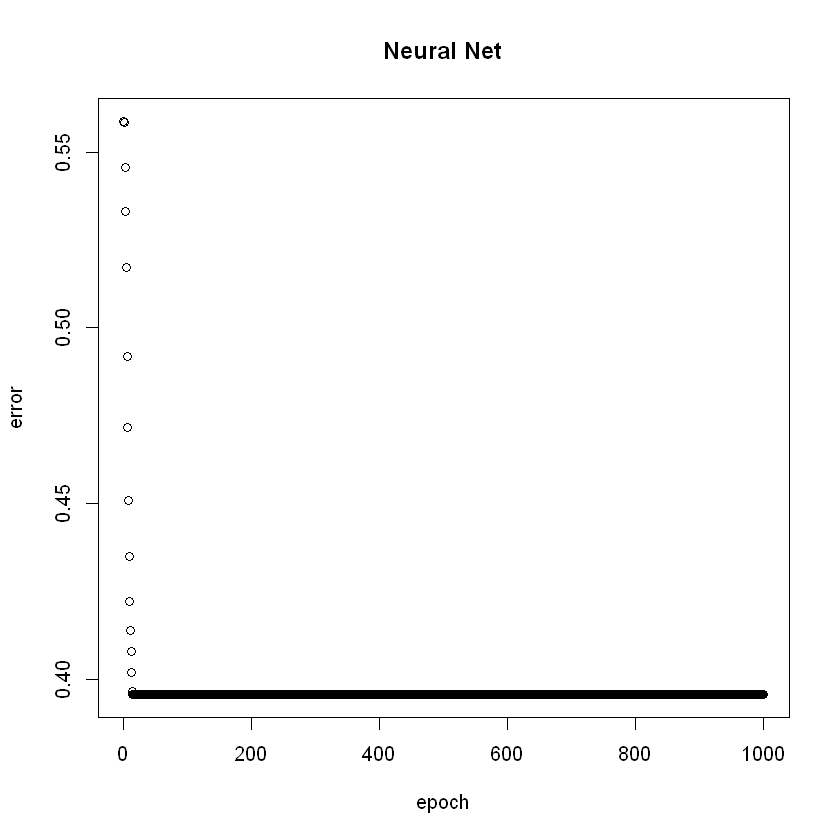

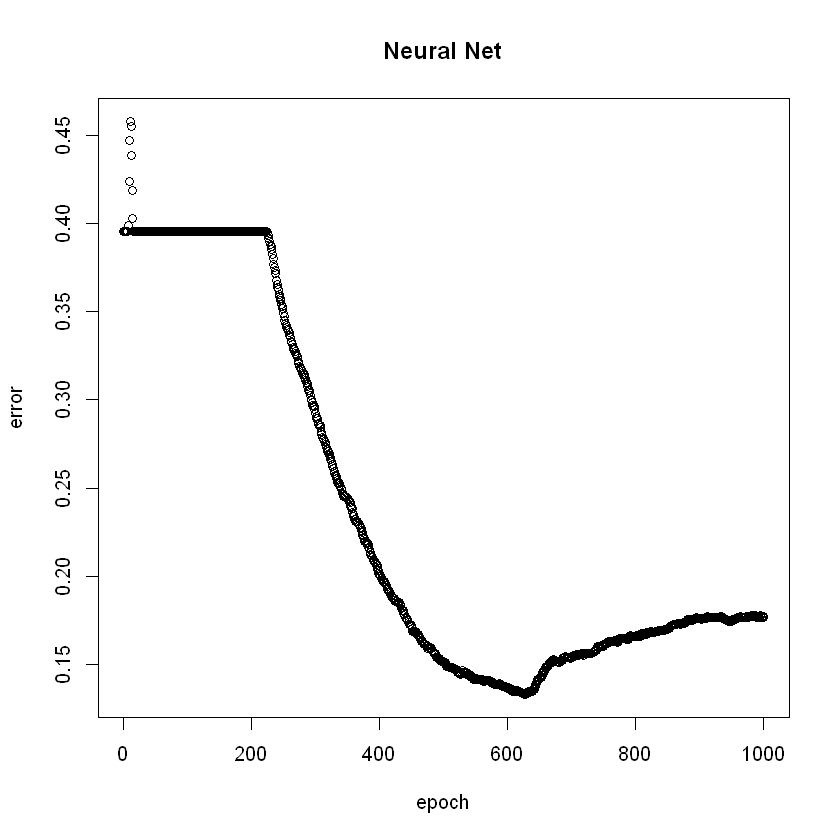

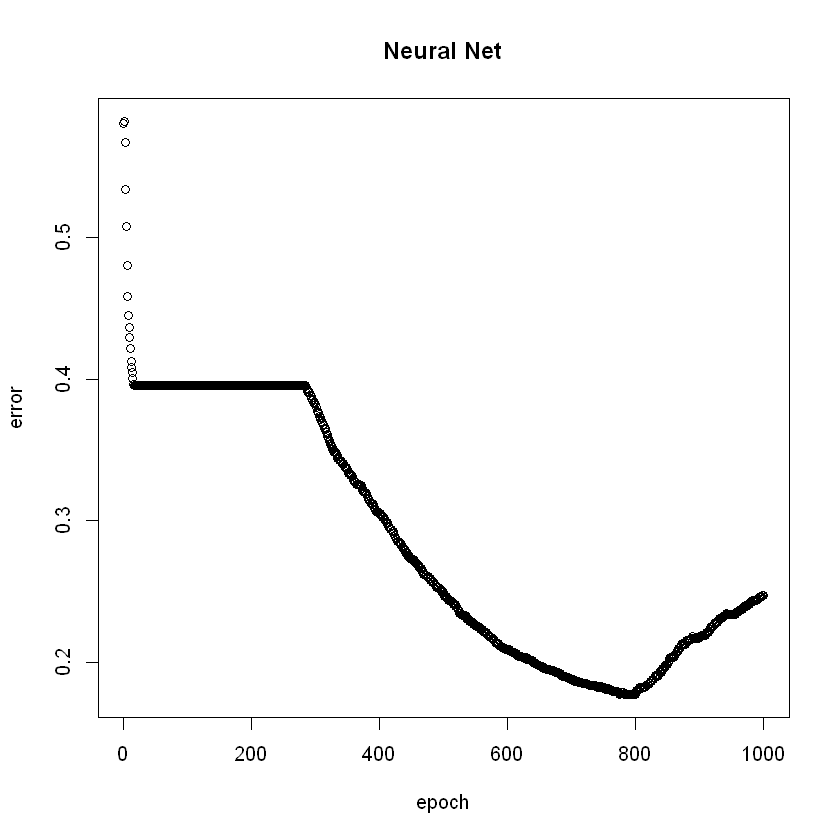

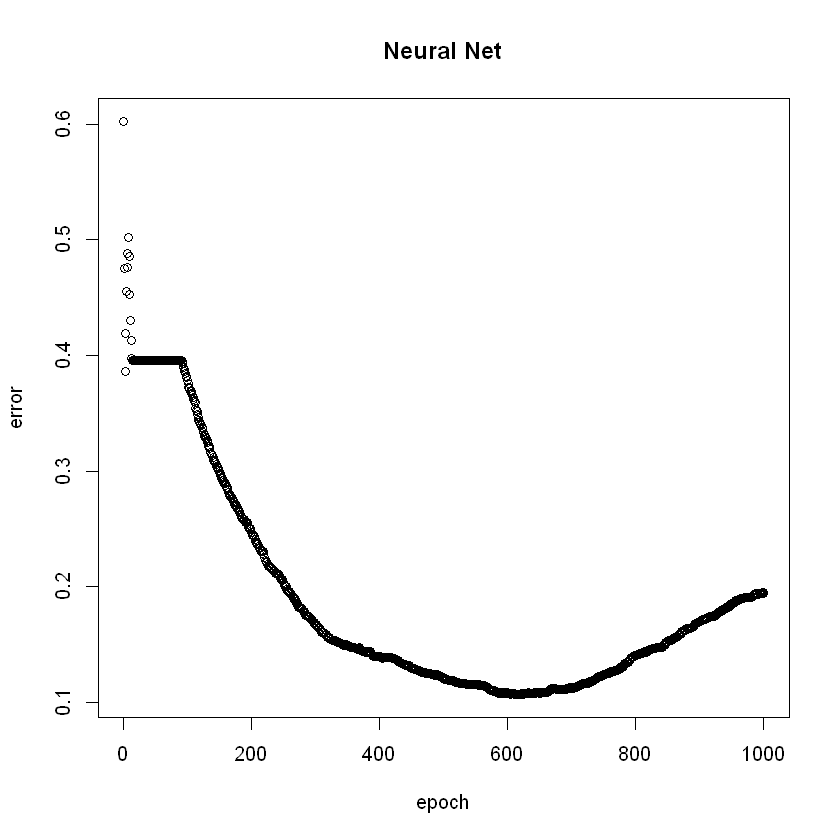

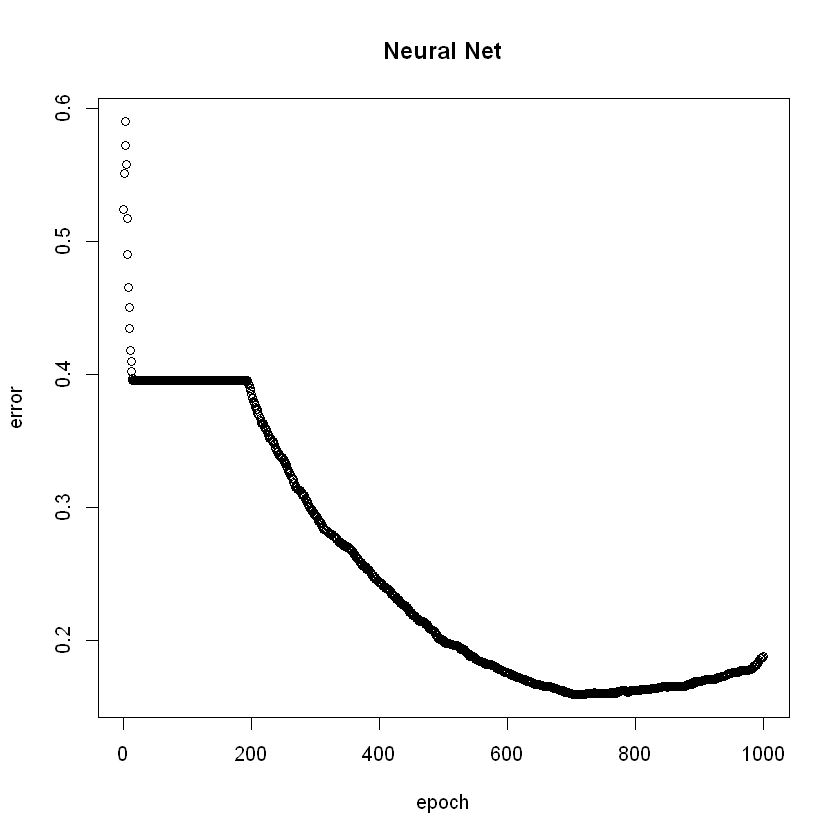

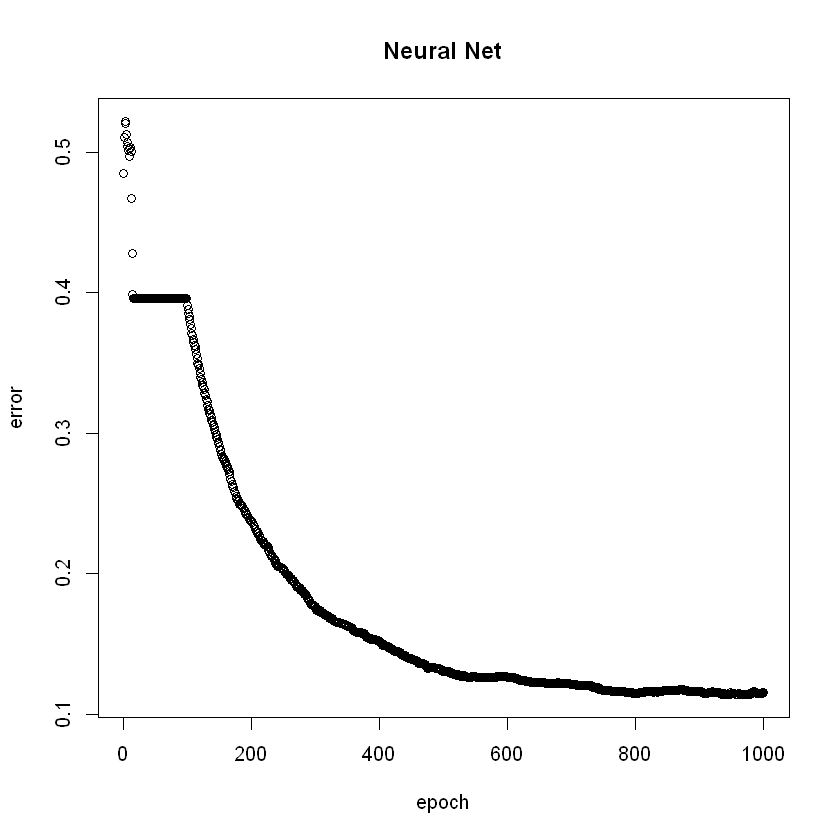

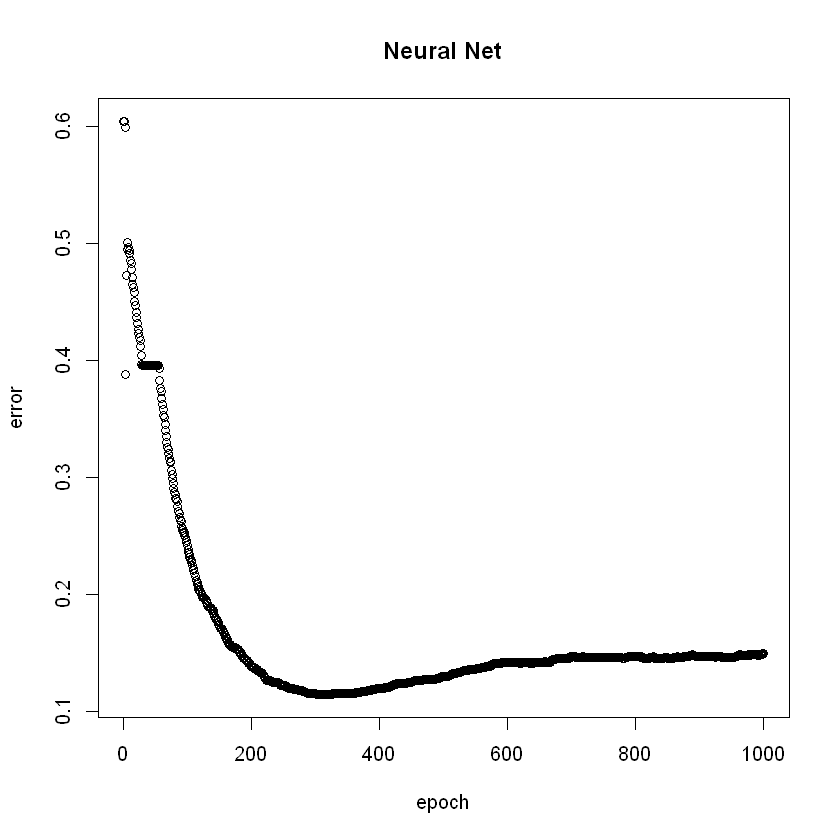

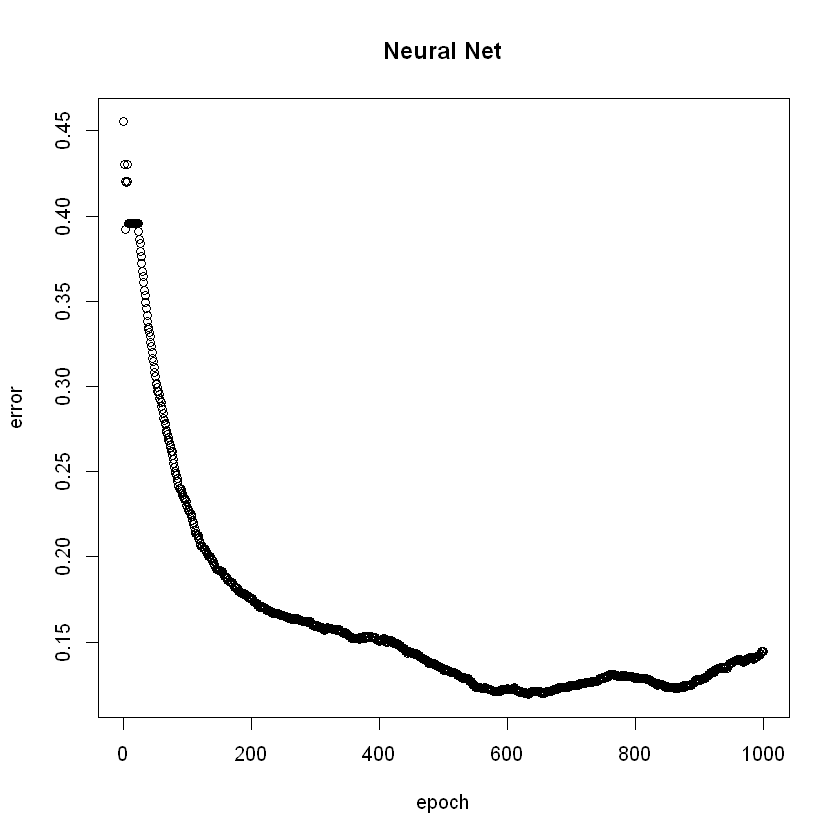

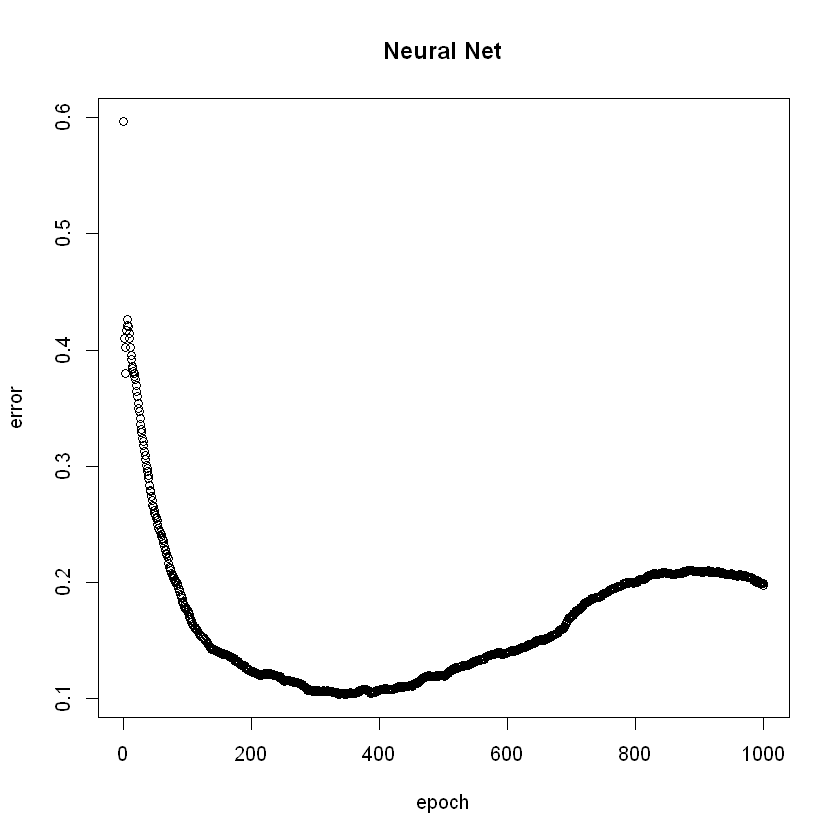

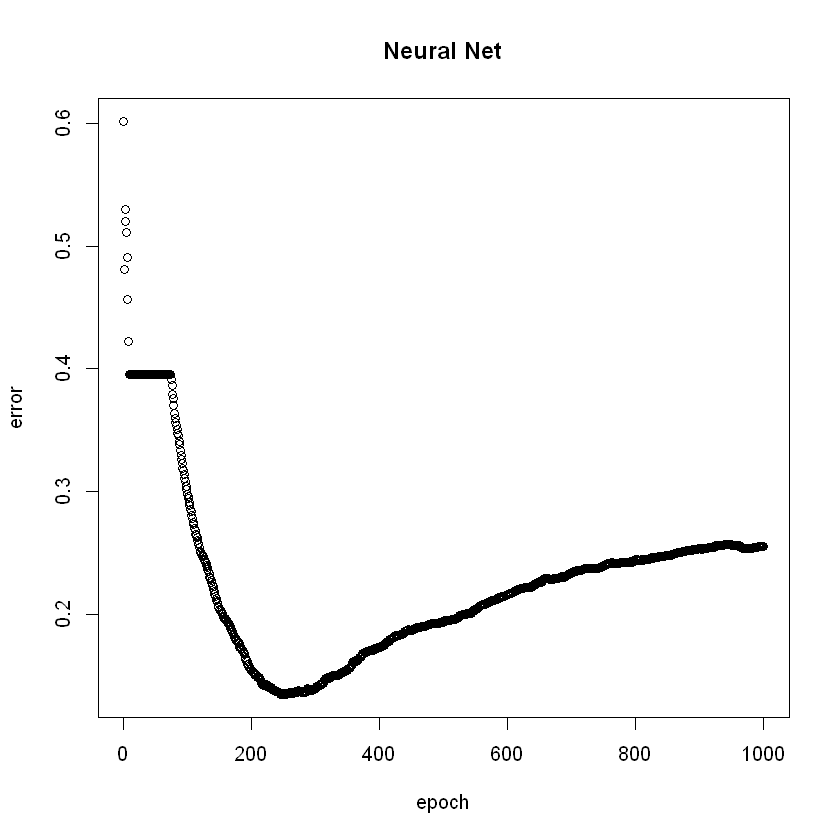

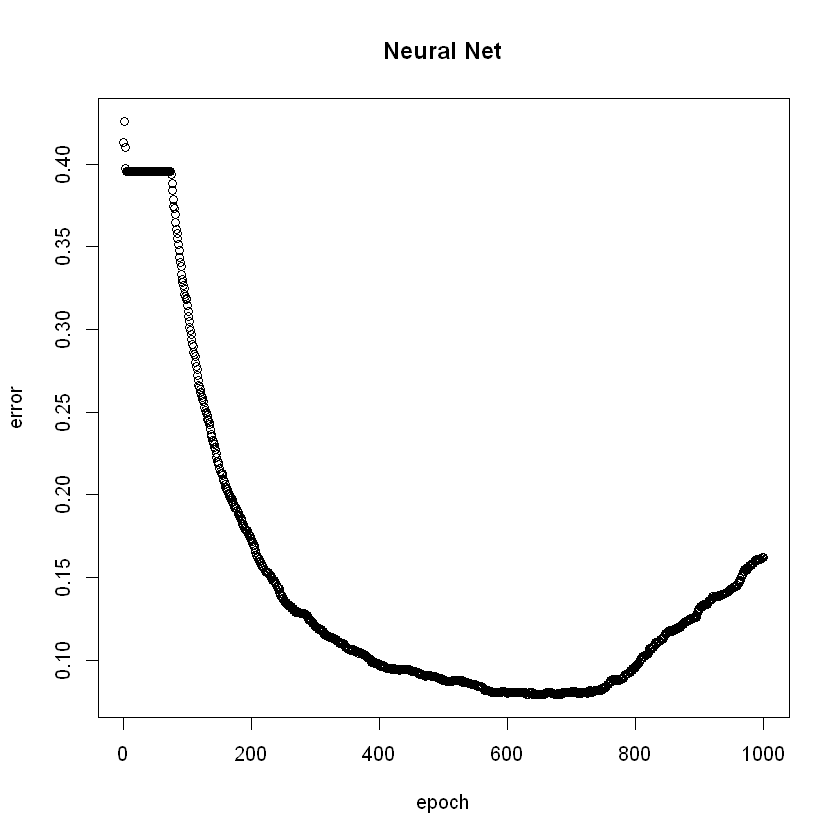

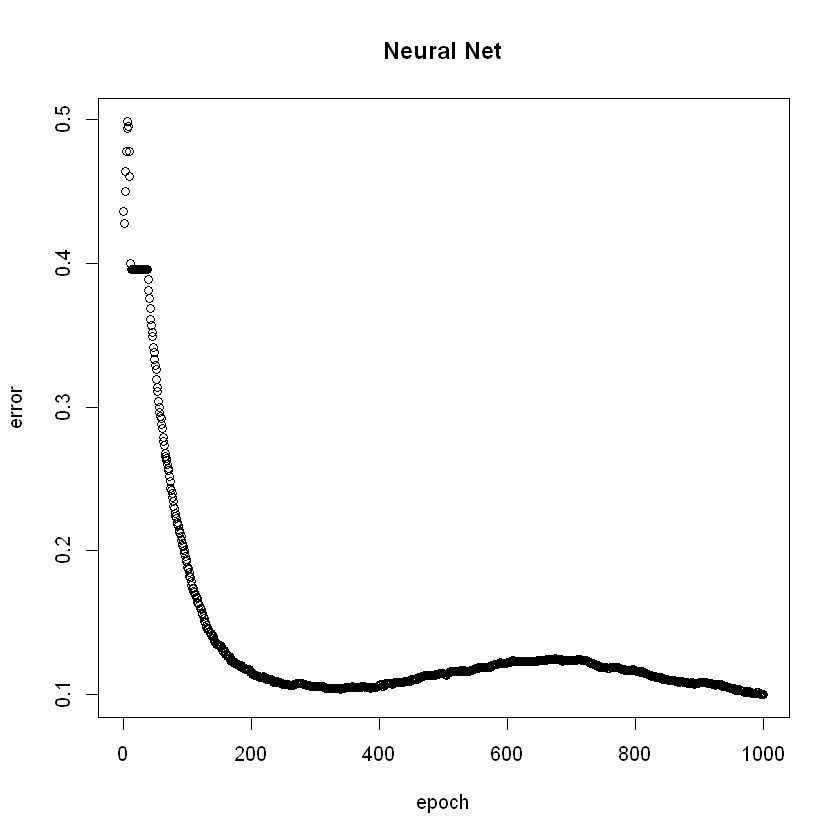

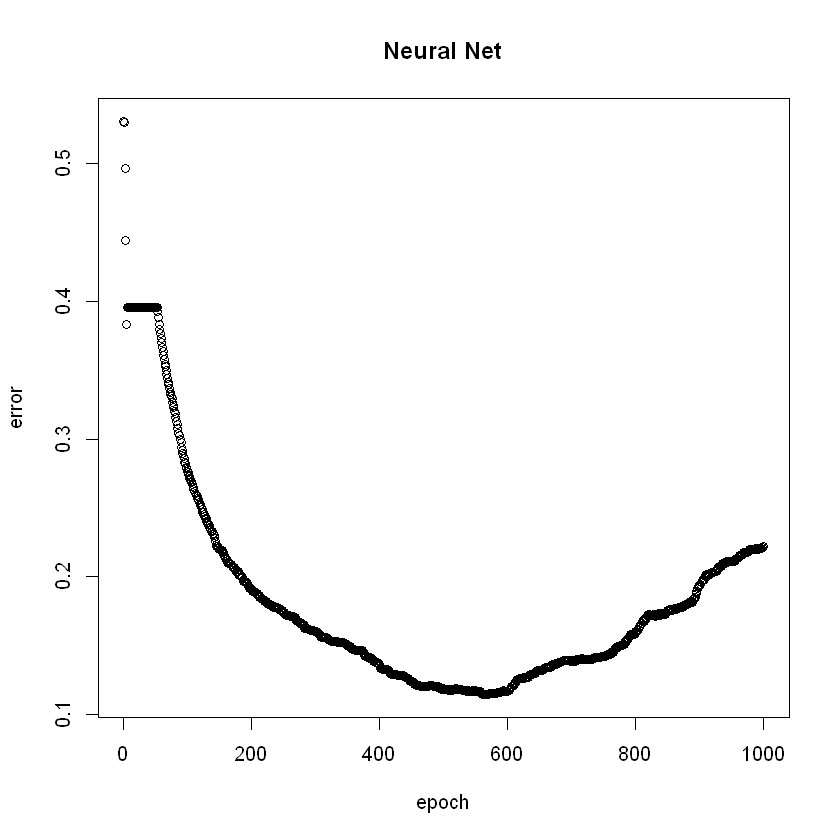

ERROR: Error in eval(expr, envir, enclos): object 'error.nn.test' not found


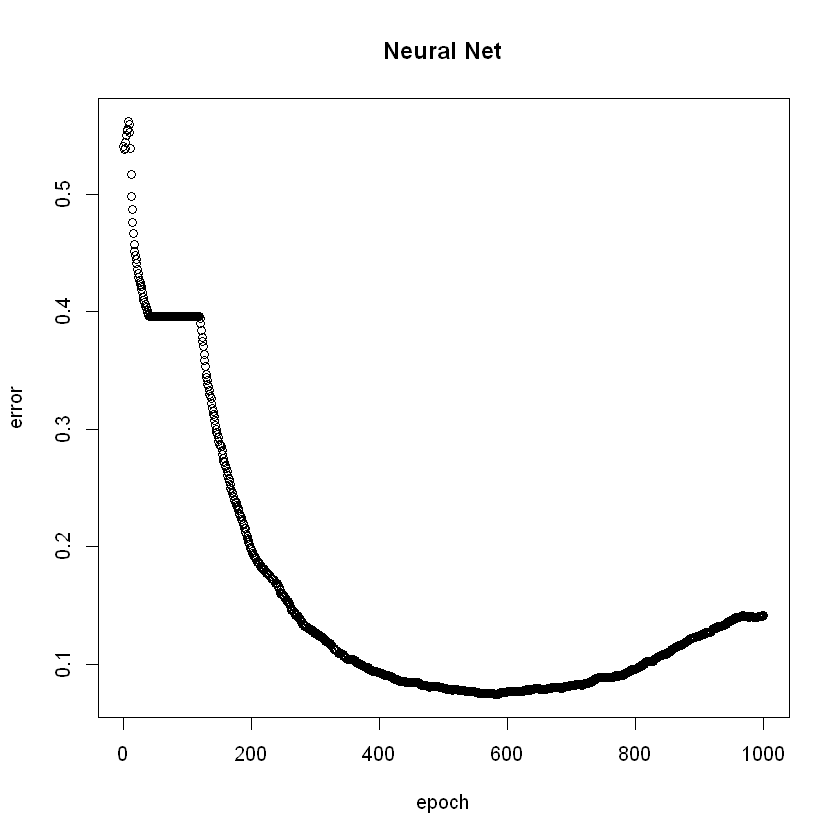

In [27]:
# Build a number of Neural Networks with different number of units in the hidden layer

# Create a data frame to store the test errors with respective number of units in hidden layer
nn_error <- data.frame('K'=seq(5,100,5),'Test Errors'=0)
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))
for (k in seq(5, 100, 5)) {
  
  list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=TRUE, epoch.max=1000, eta = 0.1, lambda = 0.01)
  
  # Evaluate the model
  predict.nn.test <- nn.predict(X2.t,W1,W2,b1,b2)
  
  # Record the test errors for plotting purposes
  nn_error[k/5,'Test Errors'] <- error.rate(predict.nn.test,T2) 

}

nn_error=error.nn.test[-2]
nn_error

We now display the test errors for varying values of K.

In [28]:
nn_error

K,Test.Errors,Test Errors
5,0,0.3908
10,0,0.3920
15,0,0.3908
20,0,0.1508
25,0,0.1832
30,0,0.2428
35,0,0.3908
40,0,0.1984
45,0,0.2384
50,0,0.1936


We now run the neural net for the best number of k.

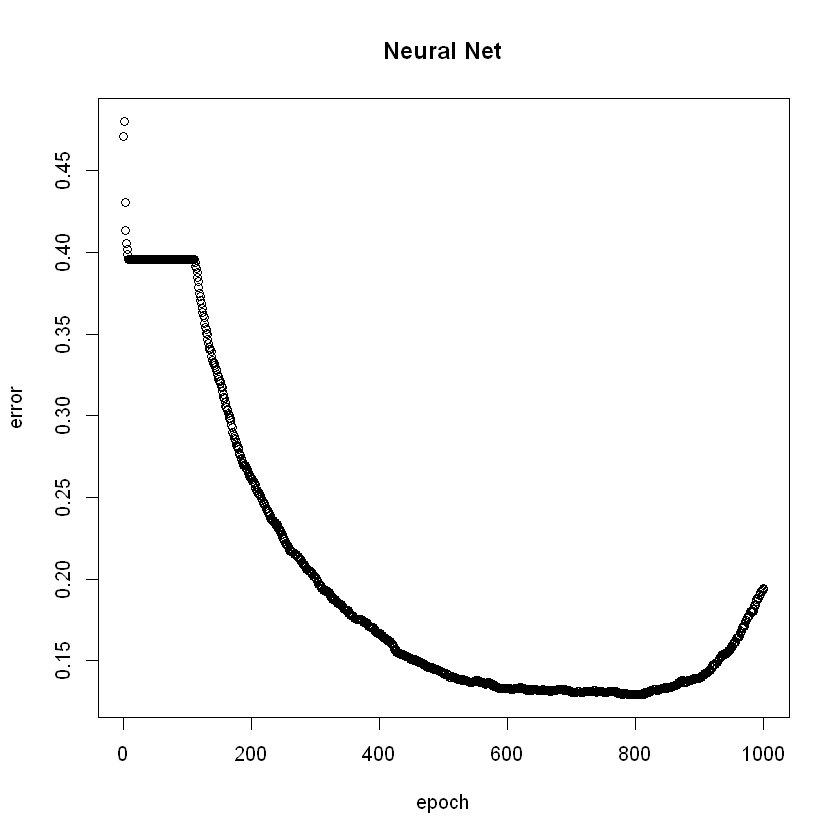

In [32]:
# Create a data frame to store the test errors with respective number of units in hidden layer
nn_error <- data.frame('K'=seq(5,100,5),'Test Errors'=0)
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))  
list[W1, W2, b1, b2]<- nn.build(60, X1.t, T1, plotting=TRUE, epoch.max=1000, eta = 0.1, lambda = 0.01)


We predict the test label using nn.predict function.

In [38]:
# Evaluate the model
  predict.nn.test <- nn.predict(X2.t,W1,W2,b1,b2)


We now transpose the predicted test labels and plot the predicted dataset.

In [39]:
predict.nn.test<-t(predict.nn.test)

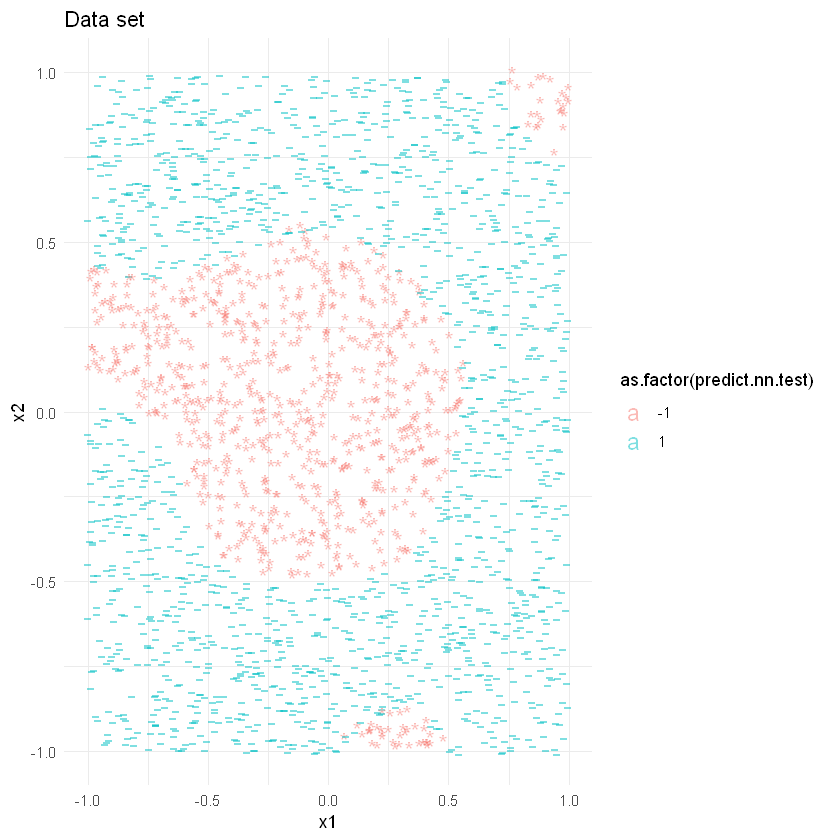

In [40]:
ggplot(data=X2, aes(x=x1, y=x2, color=as.factor(predict.nn.test), label=ifelse(predict.nn.test==+1, '-', '*'))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Data set') + theme_minimal()

We now plot the Number of neurons v/s test errors. We can see that the test error is the least for k=60 number of neurons in the hidden layer.

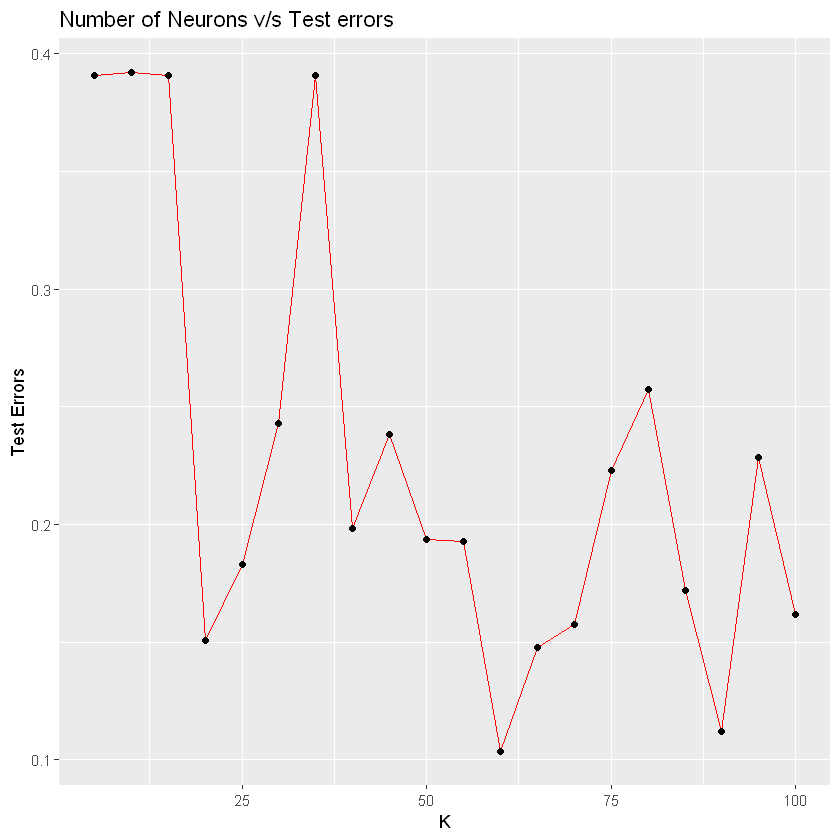

In [21]:
ggplot(data=nn_error,aes(x=K,y=Test.Errors))+
geom_line(col="red")+
geom_point()+
ggtitle("Number of Neurons v/s Test errors")+
xlab("K")+
ylab("Test Errors")